### 1. Objectives

- Quantify the extent of class imbalance (Positive, Negative, Neutral) in the Bangla Sentiment Dataset and its impact on sentiment classification performance.
- Evaluate three lightweight mitigation techniques—Synthetic Minority Oversampling Technique (SMOTE), random undersampling, and weighted loss functions—in improving model accuracy and robustness.
- Assess performance differences across dataset sources (newspapers, social media, blogs) to understand source-specific imbalance effects.

### 2. Hypotheses

- **H1**: Class imbalance in the Bangla Sentiment Dataset reduces sentiment classification performance, particularly for minority classes, as measured by per-class F1-scores.
- **H2**: Mitigation techniques (SMOTE, undersampling, weighted loss) significantly improve model performance compared to baseline models, as measured by weighted F1-score and ROC-AUC.
- **H3**: Mitigation effectiveness varies across sources (newspapers, social media, blogs) due to differences in linguistic style and imbalance patterns.



In [ ]:
# Load the dataset
import pandas as pd

# Load the Excel file
df = pd.read_excel('data-source/sentiment_dataset.xlsx', engine='openpyxl')

# Show first 5 rows
print(df.head())

In [3]:
# Convert to csv for better load speed
df.to_csv('data-source/data.csv', index=False)


# Import all necessary libraries

In [1]:
# Basic data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)

# MLflow tracking
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [2]:
# Load the csv file
df = pd.read_csv('data-source/data.csv', encoding='utf-8')

df.head()

,Tense,Label
0,জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...,0.0
1,সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...,1.0
2,দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...,0.0
3,ওনার মতো ব্যর্থ মন্ত্রীর পদত্যাগ করা উচিত,0.0
4,আল্লাহ তোদের বিচার করবে অপেক্ষা কর,0.0


## Initial Data Exploration

In [3]:
# shape of dataset
print("Shape of dataset: {}".format(df.shape))

Shape of dataset: (9162, 2)


In [4]:
# Display the column names
print("Column names in the dataset:")
print(df.columns)

Column names in the dataset:
Index(['Tense', 'Label'], dtype='object')


In [5]:
# Display the data types of each column
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
Tense     object
Label    float64
dtype: object


In [6]:
# Display information about the dataset
print("Information about the dataset:")
print(df.info())

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9162 entries, 0 to 9161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tense   9162 non-null   object 
 1   Label   9154 non-null   float64
dtypes: float64(1), object(1)
memory usage: 143.3+ KB
None


In [7]:
# Check for null values in the dataset
print("Null values in the dataset:")
print(df.isnull().sum())

Null values in the dataset:
Tense    0
Label    8
dtype: int64


In [8]:
# Check for duplicate values in the dataset
print("Duplicate values in the dataset:")
print(df.duplicated().sum())

Duplicate values in the dataset:
1412


In [9]:
# Display summary statistics of the dataset
print("Summary statistics of the dataset:")
print(df.describe())

Summary statistics of the dataset:
             Label
count  9154.000000
mean      0.856565
std       0.860452
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       2.000000


In [10]:
# Separate categorical and numerical features
categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns
print(categorical_features)
print(numerical_features)

Index(['Tense'], dtype='object')
Index(['Label'], dtype='object')


In [12]:
# Load the csv file
df = pd.read_csv("data-source/data.csv", encoding='utf-8')
# Display first few rows to verify
print(df.head())

# Check for missing values
print(df.isnull().sum()) 

                                               Tense  Label
0  জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...    0.0
1  সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...    1.0
2  দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...    0.0
3          ওনার মতো ব্যর্থ মন্ত্রীর পদত্যাগ করা উচিত    0.0
4                 আল্লাহ তোদের বিচার করবে অপেক্ষা কর    0.0
Tense    0
Label    8
dtype: int64


In [19]:
# Drop missing values
df = df.dropna()

# Check for missing values
print(df.isnull().sum()) 

Tense    0
Label    0
dtype: int64


In [20]:
# Verify unique tense and labels
print("Tense:", df['Tense'].unique())
print("Lables:", df['Label'].unique()) 

Tense: ['জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে জীবন ধারণ করা কঠিন হয়ে যাচ্ছে'
 'সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান পওয়া সম্ভব'
 'দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সরকার কী করেন ' ...
 'দয়া করে কেও ফুড পান্ডায় ওয়াডার দিবেন না'
 'আপনাদের কাছে টাকা আছে ভালো কথা  আপনারা রেষ্টুরেন্টে গিয়ে পছন্দসই খাবার অর্ডার করে গরম খাবার খাবেন'
 'এই ঘরবন্দি জীবনে ফুডপান্ডার ভুমিকা সত্যিই প্রসংশনীয় ভালো কাজের জন্যে শুভকামনা']
Lables: [0. 1. 2.]


In [21]:
# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


In [22]:
# Clean duplicate values
df = df.drop_duplicates()
# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


In [23]:
# Overall label distribution
overall_distribution = df['Label'].value_counts()
overall_distribution_percent = df['Label'].value_counts(normalize=True) * 100

print("Overall Label Distribution (Counts):")
print(overall_distribution)
print("\nOverall Label Distribution (Percentages):")
print(overall_distribution_percent)

Overall Label Distribution (Counts):
Label
0.0    3667
2.0    2251
1.0    1825
Name: count, dtype: int64

Overall Label Distribution (Percentages):
Label
0.0    47.358905
2.0    29.071419
1.0    23.569676
Name: proportion, dtype: float64


In [24]:
# Save to CSV
overall_distribution.to_csv("outputs/overall_label_distribution.csv")
overall_distribution_percent.to_csv("outputs/overall_label_distribution_percent.csv")

In [25]:
# Change the datatype of label
df['Label'] = df['Label'].astype(int)
df.head()

,Tense,Label
0,জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...,0
1,সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...,1
2,দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...,0
3,ওনার মতো ব্যর্থ মন্ত্রীর পদত্যাগ করা উচিত,0
4,আল্লাহ তোদের বিচার করবে অপেক্ষা কর,0


In [26]:
# Save the cleaned text
df.to_csv('data-source/cleaned_dataset.csv')

In [4]:
# Load dataset and check basic information
import pandas as pd

main_df = pd.read_csv("data-source/cleaned_dataset.csv")
df = main_df.copy()

# Show basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)

Dataset Shape: (7743, 3)

Columns: Index(['Unnamed: 0', 'Tense', 'Label'], dtype='object')


In [5]:
df.info()
df.nunique()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7743 entries, 0 to 7742
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7743 non-null   int64 
 1   Tense       7743 non-null   object
 2   Label       7743 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 181.6+ KB


,Unnamed: 0,Label
count,7743.000000,7743.000000
mean,4239.084851,0.817125
std,2667.500042,0.854959
min,0.000000,0.000000
25%,1978.500000,0.000000
50%,3960.000000,1.000000
75%,6145.500000,2.000000
max,9161.000000,2.000000


In [6]:
# drop unnamed column form the cleaned dataset
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

In [7]:
# Save the cleaned text
df.to_csv('data-source/cleaned_dataset.csv', index=False)

### Phase 1: Data Exploration and Imbalance Analysis

- **Objective**: Quantify class imbalance and establish baseline characteristics.
- **Steps**:
    1. Load dataset using pandas.
    2. Calculate label distribution (Positive, Negative, Neutral) overall and by source (newspapers, social media, blogs).
    3. Visualize distributions using matplotlib/seaborn (e.g., bar charts, pie charts).
    4. Identify imbalance severity (e.g., ratio of majority to minority classes).

In [8]:
# Load the dataset again
# Load dataset and check basic information
import pandas as pd

main_df = pd.read_csv("data-source/cleaned_dataset.csv")
df = main_df.copy()

# Show basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)

Dataset Shape: (7743, 2)

Columns: Index(['Tense', 'Label'], dtype='object')


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7743 entries, 0 to 7742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tense   7743 non-null   object
 1   Label   7743 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


In [12]:
df.nunique()

Tense    7579
Label       3
dtype: int64

In [13]:
df.describe()

,Label
count,7743.000000
mean,0.817125
std,0.854959
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [18]:
# Overall label distribution
overall_distribution = df['Label'].value_counts()
overall_distribution_percent = df['Label'].value_counts(normalize=True) * 100
    
print("Overall Label Distribution (Counts):")
print(overall_distribution)
print("\nOverall Label Distribution (Percentages):")
print(overall_distribution_percent)
    
# Save to CSV
overall_distribution.to_csv("outputs/overall_label_distribution.csv")
overall_distribution_percent.to_csv("outputs/overall_label_distribution_percent.csv")    

Overall Label Distribution (Counts):
Label
0    3667
2    2251
1    1825
Name: count, dtype: int64

Overall Label Distribution (Percentages):
Label
0    47.358905
2    29.071419
1    23.569676
Name: proportion, dtype: float64


### 3. Visualize the data distribution

In [25]:
# Visualize initial data distribution and correlations
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {
    0: "Negative",
    1: "Positive",
    2: "Neutral"
}

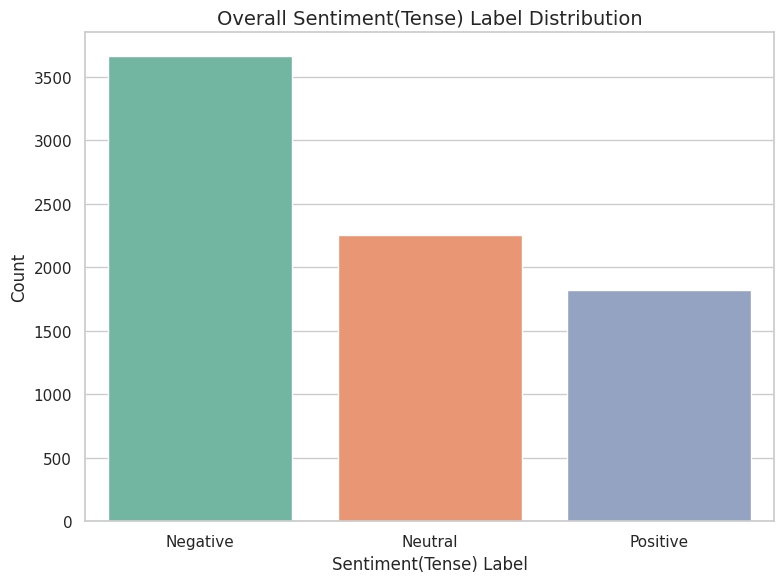

In [27]:
# Map numeric labels to descriptive names
overall_distribution_named = overall_distribution.rename(index=label_map)

# Set plot style
sns.set_theme(style="whitegrid")

# --- Bar Chart: Overall Distribution ---
plt.figure(figsize=(8, 6))
sns.barplot(x=overall_distribution_named.index, y=overall_distribution_named.values, hue=overall_distribution_named.index, legend=False, palette="Set2")

plt.title("Overall Sentiment(Tense) Label Distribution", fontsize=14)
plt.xlabel("Sentiment(Tense) Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("outputs/overall_label_distribution_bar.png")
plt.show()

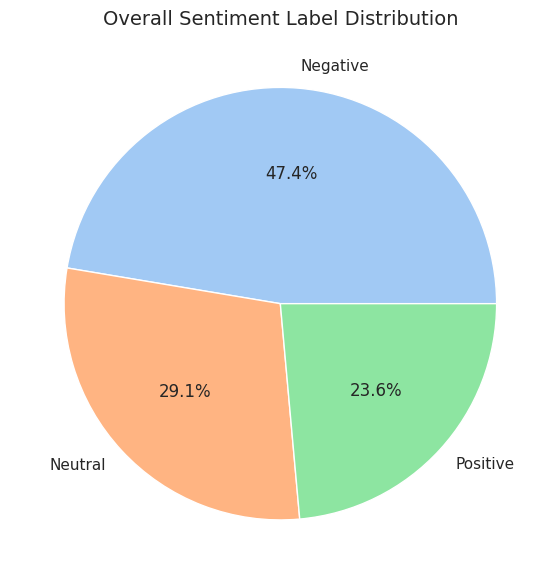

In [29]:
# --- Pie Chart: Overall Distribution ---
plt.figure(figsize=(8, 6))
plt.pie(overall_distribution_named.values, labels=overall_distribution_named.index,
        autopct='%1.1f%%', colors=sns.color_palette("pastel"))

plt.title("Overall Sentiment Label Distribution", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/overall_label_distribution_pie.png")
plt.show()

### Step 4: Identify Imbalance Severity

- **Objective**: Quantify imbalance severity using the ratio of majority to minority classes.
- **Instructions**:
    1. **Calculate Ratios**: Compute the ratio of the majority class (highest count) to the minority class (lowest count) overall
    2. **Classify Severity**: Use thresholds (e.g., ratio > 1.5 = moderate, > 10 = severe) to assess imbalance.
    3. **Document Findings**: Summarize in a report, noting implications for model bias (e.g., favoring Neutral if dominant).


* **Imbalance Ratio** refers to the ratio between the **most frequent** class and the **least frequent** class in the dataset.
* In this case:

  $$
  \text{Imbalance Ratio} \approx \frac{\text{Majority class count}}{\text{Minority class count}}
  $$

In [36]:

# Compute majority and minority class counts
majority_class_count = overall_distribution.max()
minority_class_count = overall_distribution.min()

# Safely compute imbalance ratio
imbalance_ratio = (majority_class_count / minority_class_count) if minority_class_count > 0 else float("inf")

# Print with context
print(f"\n Imbalance Ratio (Majority / Minority): {imbalance_ratio:.2f}")
print(f"   - Majority class count: {majority_class_count}")
print(f"   - Minority class count: {minority_class_count}\n")

# Save ratio to a well-formatted CSV
imbalance_df = pd.DataFrame({
    "Metric": ["Imbalance Ratio"],
    "Value": [imbalance_ratio]
})
imbalance_df.to_csv("outputs/imbalance_ratios.csv", index=False)


 Imbalance Ratio (Majority / Minority): 2.01
   - Majority class count: 3667
   - Minority class count: 1825



A ratio of 2.01 indicates a **moderate imbalance** — the Negative class appears twice as often as the Positive class.

While this isn't considered extreme, it can:

* Bias models toward predicting the majority class (Negative).

* Result in lower recall and precision for the Positive class if not handled properly.

* The Neutral class (29.07%) is closer to balance but still significantly less than Negative.

## Phase 2: Preprocessing and Dataset Preparation

**Objective**: Prepare the Bangla Sentiment Dataset (columns: Tense, Label) for model training, ensuring compatibility with traditional (TF-IDF-based) and neural (BanglaBERT) sentiment classification models while preserving class imbalance characteristics.


### Step 1: Clean Text (Remove Noise, Normalize Bangla Script)

- **Objective**: Clean the `Tense` column to remove noise (e.g., special characters, URLs) and normalize Bangla text for consistency.

In [1]:
%pip install bnlp_toolkit

  Using cached bnlp_toolkit-4.0.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached sklearn_crfsuite-0.3.6-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached tqdm-4.66.3-py3-none-any.whl.metadata (57 kB)
  Using cached ftfy-6.2.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached emoji-1.7.0-py3-none-any.whl
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached python_crfsuite-0.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [3]:
import pandas as pd
import re
from bnlp import CleanText
    
# Initialize BNLP cleaner
clean_text = CleanText(
    fix_unicode=True,
    unicode_norm=True,
    unicode_norm_form="NFKC",
    remove_url=False,
    remove_email=False,
    remove_emoji=False,
    remove_number=False,
    remove_digits=False,
    remove_punct=False,
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_number="<NUMBER>",
    replace_with_digit="<DIGIT>",
    replace_with_punct = "<PUNC>"
)

In [ ]:
# Load the dataset from phase 1
dataset_path = "data-source/cleaned_dataset.csv"
df = pd.read_csv(dataset_path, encoding="utf-8")

df.head(3)

,Tense,Label
0,জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...,0
1,সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...,1
2,দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...,0


In [7]:
# Clean text using BNLP
def preprocess_text(text):
    # BNLP cleaning
    cleaned = clean_text(text)
    # Additional regex for URLs/hashtags (if BNLP misses any)
    cleaned = re.sub(r'http\S+|#\S+', '', cleaned)
    # Remove extra spaces
    cleaned = ' '.join(cleaned.split())
    return cleaned

df['Tense_Cleaned'] = df['Tense'].apply(preprocess_text)
    
# Check sample
print("Sample Cleaned Text:")
print(df[['Tense', 'Tense_Cleaned']].head(5))

Sample Cleaned Text:
                                               Tense  \
0  জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...   
1  সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...   
2  দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...   
3          ওনার মতো ব্যর্থ মন্ত্রীর পদত্যাগ করা উচিত   
4                 আল্লাহ তোদের বিচার করবে অপেক্ষা কর   

                                       Tense_Cleaned  
0  জিনিসপত্রের অতিরিক্ত দাম বৃদ্ধির জন্য এই শহরে ...  
1  সঠিক ভাবে তদারকি করলে এই সমস্যা থেকে পরিত্রান ...  
2  দেশের টাকা যখন বিদেশে চোলে যাচ্ছে তখন দেশের সর...  
3          ওনার মতো ব্যর্থ মন্ত্রীর পদত্যাগ করা উচিত  
4                 আল্লাহ তোদের বিচার করবে অপেক্ষা কর  


In [8]:
# Save the cleaned dataset
df.to_csv("outputs/cleaned_dataset.csv", encoding='utf-8', index=False)

In [9]:
df['Tense_Cleaned'].isnull().sum()

0

### Step 2: Tokenize Texts for Traditional (TF-IDF) and Neural Models (BanglaBERT-Compatible Tokens)

- **Objective**: Tokenize cleaned text for traditional models (TF-IDF vectors) and neural models (BanglaBERT tokens).

In [10]:
# Install necessary libraries
%pip install scikit-learn
%pip install transformers

Note: you may need to restart the kernel to use updated packages.
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 1.4 MB/s eta 0:00:0000:010:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.4 MB/s eta 0:00:00a 0:00:01
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [transformers] [transformers]ub]
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Import necessary libraries
from bnlp import NLTKTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer
import numpy as np